## Preliminaries for data processing and analysis

In [1]:
%matplotlib inline
import re
import numpy as np
import pandas

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", palette="pastel", color_codes=True)

from scipy.stats import norm
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.svm import SVC
from sklearn.cross_validation import cross_val_score,LeaveOneOut,ShuffleSplit,KFold
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.preprocessing import scale,normalize
from sklearn.multiclass import OneVsRestClassifier,OneVsOneClassifier,OutputCodeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA,NMF

import scratch as s
from __init__ import correct

/Users/rgerkin/Dropbox/miniconda3/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
import pandas as pd

joe = pd.read_excel('bbdp/data/ST_29Mar2016.xlsx')
joe.index = joe['donor_id']
print(joe.shape)

# Remove any UPSIT tests before the last one for each subject (so that each subject only appears once)
styear_maxes = joe.groupby(['donor_id']).styear.transform(max)
joe = joe[joe.styear == styear_maxes]
print(joe.shape)

for q in range(1,41):
    joe['smell_%d' % q].fillna(0,inplace=True)
joe['upsit_sum'] = sum(joe['smell_%d' % q] for q in range(1,41))
joe = joe[joe['upsit_sum']>0] # Drop subjects who don't have individual responses recorded
print(joe.shape)

clinpath = pd.read_excel('bbdp/data/Clinicopathological Correlations.xls')
clinpath.index = clinpath['Donor ID']
df = joe.join(clinpath,how='inner')
print(df.shape)

df[df['Last MMSE Test Score']<999.0] # Drop subjects with no MMSE test score recorded
df['dementia'] = (df['Clinpath AD']==1) | (df['Clinpath DLB']==1) | (df['Clinpath FTLD-TDP43']==1) | \
                       (df['Clinpath VaD']==1) | (df['Dementia Nos']==1) # Set a binary dementia feature.  
print(df.shape)

(615, 48)
(422, 48)
(282, 49)
(198, 146)
(198, 147)


In [3]:
# Add gender and smell features including all the UPSIT question responses.  
keep = ['Last MMSE Test Score',]
clin = df.loc[:,keep+['smell_%d' % q for q in range(1,41)]]
clin['Gender'] = df['Gender']-1
#clin['smoked_in_last_30_days'] = clin['smoked_in_last_30_days'].fillna(0)
clin['smell_reduced'] = df['smell_reduced_or_absent'].fillna(0)==1 # Impute NaN with 0 for qualitative smell assessment.  
clin['smell_absent'] = df['smell_reduced_or_absent'].fillna(0)==2 # Impute NaN with 0 for qualitative smell assessment.   
df['Expired Age'] = np.where(df['Expired Age'] == 900, 95, df['Expired Age'])
mean_mmse = df[df['Last MMSE Test Score']<999]['Last MMSE Test Score'].mean()
clin['Last MMSE Test Score'] = np.where(clin['Last MMSE Test Score'] > 100, mean_mmse, clin['Last MMSE Test Score'])
clin['age'] = (df['Expired Age'] - (df['deathyear'] - df['styear']))
#for age in np.arange(65,95,5):
#    clin['age > %d' % age] = (df['Expired Age'] - (df['deathyear'] - df['styear'])) >= age # Determine the age at test time.
    
# Replace the actual UPSIT responses ('a', 'b', etc.) with indicator variables (1 or 0)
# reflecting whether they selected 'a', 'b', etc.  
for q in range(1,41):
    for i,letter in enumerate(['a','b','c','d']):
        clin['upsit_%d%s' % (q,letter)] = clin['smell_%d' % q]==(i+1)
    clin['upsit_%d_responded' % (q)] = clin['smell_%d' % q]>0
    clin['upsit_%d_correct' % (q)] = clin['smell_%d' % q]==correct[q-1]
    clin.drop('smell_%d' % q,axis=1,inplace=True)
clin['upsit_total_responded'] = sum([clin['upsit_%d_responded' % q] for q in range(1,41)])
clin['upsit_total_correct'] = sum([clin['upsit_%d_correct' % q] for q in range(1,41)])
#for i in np.arange(0,40,5):
#    clin['upsit_total_correct > %d' % i] = clin['upsit_total_correct']>i    
clin = clin*1
n_nmf = 0
if n_nmf:
    pattern_features = [feature for feature in clin if re.match('upsit_[0-9]+',feature)]
    nmf = NMF(n_components=n_nmf)
    nmf_pattern_features = pd.DataFrame(nmf.fit_transform(clin[pattern_features]),
                                        index=clin.index,
                                        columns=['upsit_%d_nmf' % i for i in range(n_nmf)])
    clin = clin.drop(pattern_features,axis=1).join(nmf_pattern_features)

In [4]:
((df['Clinpath PD']==0) & (df['Clinpath AD']==0) & (df['Clinpath PSP']==0)).sum()

80

In [5]:
mnb = MultinomialNB(alpha=1.0,fit_prior=False) # Multinomial Naive Bayes classifier.  
bnb = BernoulliNB(alpha=1.0,fit_prior=False) # Bernoulli Naive Bayes classifier.  
gnb = GaussianNB() # Gaussian Naive Bayes classifier.  
rfc = RandomForestClassifier(max_depth=5,random_state=0) # Multinomial Naive Bayes classifier. 
svm = SVC(probability=True,C=1.0,random_state=0)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis,QuadraticDiscriminantAnalysis
lda = LinearDiscriminantAnalysis(shrinkage='auto',solver='eigen')#n_components=10)
qda = QuadraticDiscriminantAnalysis()

#for key in keys:
#    loo = LeaveOneOut(len(Y[key])) # The "leave one out" cross-validation split.  
#    for use in uses:
#        s.cross_validate(mnb,X[key][use],Y[key],loo,"'%s: %s'" % (key,use)) # Run cross-validation with MNB classifier on TC.  

In [6]:
def make_x(clin,df):
    x = {}
    x['pd'] = clin[df['Clinpath PD']==1]
    x['no_pd'] = clin[df['Clinpath PD']==0]
    x['pd_only'] = clin[(df['Clinpath PD']==1) & (df['dementia']==0)]#df['Clinpath AD']==0) & (df['Clinpath DLB']==0) & \
                 #(df['Clinpath FTLD-TDP43']==0) & (df['Clinpath VaD']==0) & (df['Dementia Nos']==0)]
    x['ctrl'] = clin[(df['Clinpath Control']==1) & (df['Clinpath PSP']==0)]
    x['psp no_pd'] = clin[(df['Clinpath PSP']==1) & (df['Clinpath PD']==0) & (df['dementia']==0)]
    x['pd no_psp'] = clin[(df['Clinpath PSP']==0) & (df['Clinpath PD']==1) & (df['dementia']==0)]
    x['ad'] = clin[df['Clinpath AD']==1]
    x['no_ad'] = clin[df['Clinpath AD']==0]
    x['ad_only'] = clin[(df['Clinpath AD']==1) & (df['Clinpath PD']==0) & (df['Clinpath DLB']==0) & \
                 (df['Clinpath FTLD-TDP43']==0) & (df['Clinpath VaD']==0) & (df['Dementia Nos']==0)]
    x['ctrl'] = clin[df['Clinpath Control']==1]
    return x

x = make_x(clin,df)

In [7]:
keys = {'pd vs no_pd':'PD Diagnosis, +comorbidities',
        'pd_only vs ctrl':'PD Diagnosis',
        'ad vs no_ad':'AD Diagnosis, +comorbidities',
        'ad_only vs ctrl':'AD Diagnosis',
        'pd no_psp vs psp no_pd':'PD vs PSP',
        'psp no_pd vs ctrl':'PSP Diagnosis'}
uses = {'Which Responses':['upsit_total'],
        'Which Correct':['upsit_[0-9]+[a-d]'],
        'Total Score':['upsit_[0-9]+[a-d]','upsit_[0-9]+','upsit_total_responded'],
        'No UPSIT':['upsit'],
        #'No Smell':['smell','upsit']
        }

def makeXY(keys,uses,clin,x,drop_more=[]):
    X = {key:{} for key in keys}
    Y = {}
    for key in keys:
        pos,neg = [_.strip() for _ in key.split('vs')]
        n = len(x[pos])+len(x[neg])
        #order = np.random.permutation(range(n))
        for use,regex in uses.items():
            drop = []
            for reg in regex:
                drop += [feature for feature in list(clin) if re.match(reg,feature)]
            drop = list(set(drop))
            drop += drop_more
            x_new = np.vstack([x[_].drop(drop,axis=1).as_matrix() for _ in (pos,neg)])
            #x_new = normalize(x_new,norm='max',axis=0)
            from sklearn.decomposition import PCA,NMF
            #pca = PCA(n_components = min(10,x_new.shape[1]))
            #nmf = NMF(n_components = min(5,x_new.shape[1]))
            #x_new = pca.fit_transform(x_new)
            #x_new = nmf.fit_transform(x_new)
            X[key][use] = x_new#[order,:]
        Y[key] = np.concatenate((np.ones(x[pos].shape[0]),np.zeros(x[neg].shape[0])))#[order]
    return X,Y

X,Y = makeXY(keys,uses,clin,x)

In [8]:
def make_py(keys,uses,X,Y,clfs):
    p_pos = {}
    ys = {}
    for key in keys:
        #splits = LeaveOneOut(len(Y[key])) # The "leave one out" cross-validation split.  
        splits = ShuffleSplit(len(Y[key]),n_iter=25,test_size=0.2,random_state=0)
        p_pos[key] = {}
        for use in uses:
            p_pos[key][use] = {}
            #x = 0
            for clf in clfs:
                p,ys[key] = s.get_ps(clf,splits,X[key][use],Y[key]); # Extract the probability of PD from each classifier
                #x -= norm.isf(p) # Turn it into a score in (-inf,inf) and add it to a running score total
                #x /= len(clfs) # Normalize the score by the number of classifiers
                #p = norm.cdf(x) # Convert the score back into a probability
                p_pos[key][use][str(clf)[:7]] = p.clip(1e-15,1-1e-15)
    return p_pos,ys

clfs = [lda,svm]#[bnb,gnb,svm,rfc,lda,qda]
p_pos,ys = make_py(keys,uses,X,Y,clfs)

/Users/rgerkin/Dropbox/miniconda3/lib/python3.5/site-packages/sklearn/covariance/shrunk_covariance_.py:193: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "
/Users/rgerkin/Dropbox/miniconda3/lib/python3.5/site-packages/sklearn/covariance/empirical_covariance_.py:75: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "
/Users/rgerkin/Dropbox/miniconda3/lib/python3.5/site-packages/sklearn/covariance/shrunk_covariance_.py:193: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "
/Users/rgerkin/Dropbox/miniconda3/lib/python3.5/site-packages/sklearn/covariance/empirical_covariance_.py:75: UserWarning: Only one sample available. You may want to reshape your data array
  warnings.warn("Only one sample available. "
/Users/rgerkin/Dropbox/miniconda3/lib/python3.5/site-package

In [9]:
def make_average_p(p_pos,clfs):
    for key in p_pos:
        for use in p_pos[key]:
            xp = 0
            p = 0
            for clf in clfs:
                p += p_pos[key][use][str(clf)[:7]]
                #xp -= norm.isf(p)
            p_pos[key][use]['average'] = p/len(clfs)#norm.cdf(xp/len(clfs))
    return p_pos
                         
p_pos = make_average_p(p_pos,clfs)

0.657638333412 0.5286 0.5164 32 144
0.789482400779 0.6841 0.6917 32 144
0.825563252017 0.7252 0.7439 32 144
0.826842758154 0.7359 0.7357 32 144
Total Score vs No UPSIT: p=0.0037
Which Correct vs No UPSIT: p=0.0004
Which Correct vs Total Score: p=0.1157
Which Responses vs No UPSIT: p=0.0003
Which Responses vs Total Score: p=0.1086
Which Responses vs Which Correct: p=0.2445
0.848542565435 0.0562 0.0396 12 3


/Users/rgerkin/Dropbox/science/upsit/scratch.py:248: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(sd)


0.603543911028 0.2426 0.1472 12 3
0.917935573384 0.0106 0.0382 12 3
0.922669399435 0.0069 0.0381 12 3
Total Score vs No UPSIT: p=nan
Which Correct vs No UPSIT: p=nan
Which Correct vs Total Score: p=nan
Which Responses vs No UPSIT: p=nan
Which Responses vs Total Score: p=nan
Which Responses vs Which Correct: p=nan
0.907969924132 0.8567 0.8589 34 69
0.883870511638 0.8132 0.8301 34 69
0.872379689341 0.7962 0.808 34 69
0.899963457842 0.8516 0.8514 34 69
Total Score vs No UPSIT: p=0.1397
Which Correct vs No UPSIT: p=0.0969
Which Correct vs Total Score: p=0.1981
Which Responses vs No UPSIT: p=0.2110
Which Responses vs Total Score: p=0.1774
Which Responses vs Which Correct: p=0.1307
0.666533459356 0.2525 0.123 3 69
0.503369726178 0.3283 0.3425 3 69
0.668619040087 0.1923 0.1435 3 69
0.856254124482 0.0625 0.0235 3 69
Total Score vs No UPSIT: p=nan
Which Correct vs No UPSIT: p=nan
Which Correct vs Total Score: p=nan
Which Responses vs No UPSIT: p=nan
Which Responses vs Total Score: p=nan
Which R

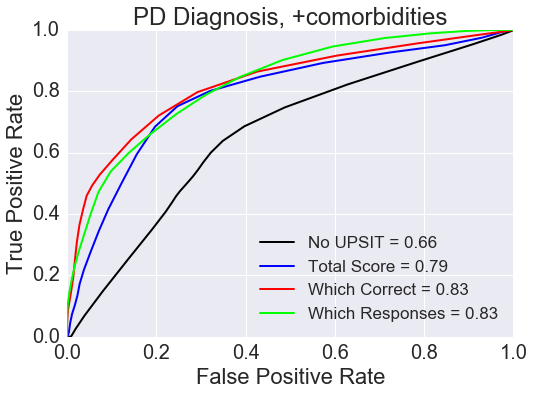

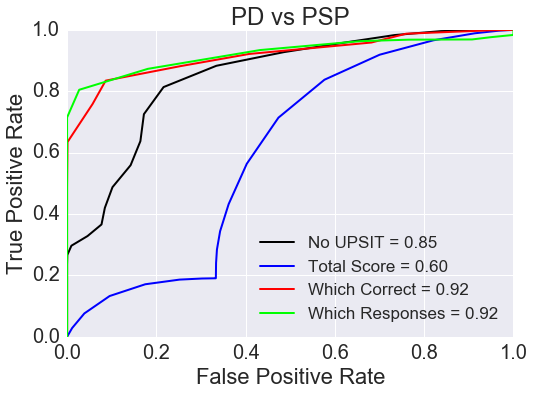

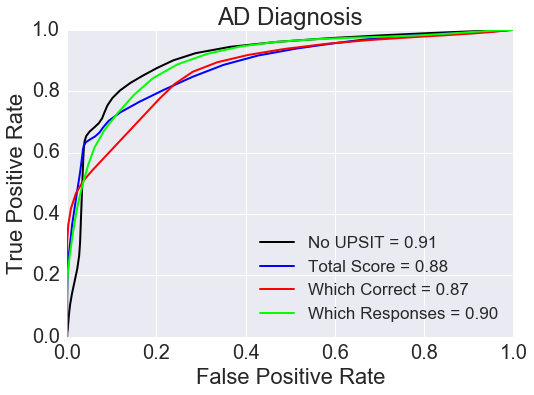

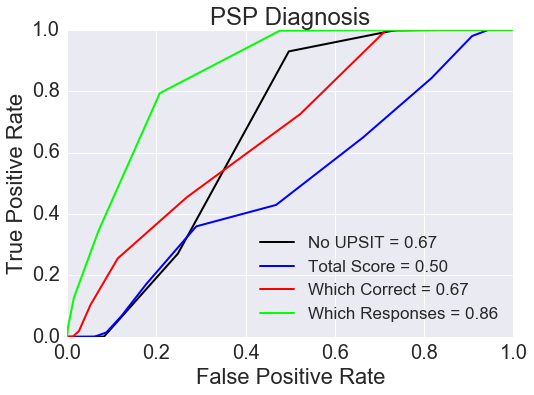

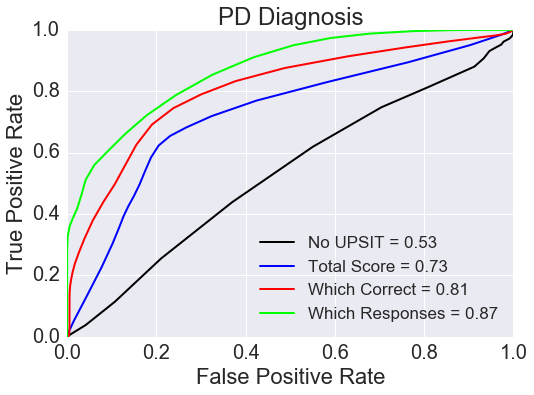

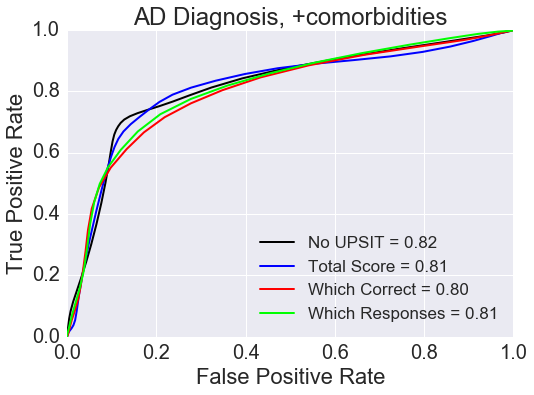

In [10]:
sns.set(font_scale=2)
for key in keys:
    plt.figure()
    d = {use:p_pos[key][use]['average'] for use in uses}
    n0 = sum(Y[key]==0)
    n1 = sum(Y[key]>0)
    aucs,aucs_se = s.plot_roc_curve(ys[key],n0=n0,n1=n1,smooth=True,**d)
    for i,(a1,se1) in enumerate(zip(aucs,aucs_se)):
        for j,(a2,se2) in enumerate(zip(aucs,aucs_se)):
            if i>j:
                d = np.abs((a1-a2)/np.sqrt((se1**2 + se2**2)/2))
                p = (1-norm.cdf(d,0,1))/2
                print("%s vs %s: p=%.4f" % (sorted(uses)[i],sorted(uses)[j],p))
    plt.title(keys[key])

/Users/rgerkin/Dropbox/miniconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
/Users/rgerkin/Dropbox/miniconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
/Users/rgerkin/Dropbox/miniconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
/Users/rgerkin/Dropbox/miniconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
/Users/rgerkin/Dropbox/miniconda3/lib/python3.5/site-package

0.682655291274 0.5147 0.5235 161 739
0.762136914202 0.6458 0.644 161 739
0.773104770282 0.6769 0.6687 161 739
0.757456448017 0.6442 0.6324 161 739
0.727320368899 0.1272 0.1473 63 12


/Users/rgerkin/Dropbox/science/upsit/scratch.py:248: RuntimeWarning: invalid value encountered in sqrt
  se = np.sqrt(sd)


0.507060918011 0.3313 0.3027 63 12
0.918417981435 0.0081 0.0547 63 12
0.909286397425 0.0085 0.0586 63 12
0.504880700992 0.3092 0.3504 185 340
0.676791545157 0.5186 0.5511 185 340
0.674538942386 0.5176 0.5437 185 340
0.684109239843 0.533 0.5655 185 340
0.63319723337 0.2589 0.1814 17 358
0.732734163214 0.1704 0.0746 17 358
0.786829875864 0.1117 0.0538 17 358
0.822273570497 0.1036 0.0345 17 358
0.523612737101 0.3037 0.312 60 365
0.758339438746 0.6182 0.6483 60 365
0.832197963099 0.7375 0.7556 60 365
0.898304537877 0.8412 0.8342 60 365
0.58966570868 0.2271 0.2403 334 566
0.549993928163 0.2826 0.2822 334 566
0.558307852562 0.396 0.3905 334 566
0.533406138086 0.3683 0.3621 334 566


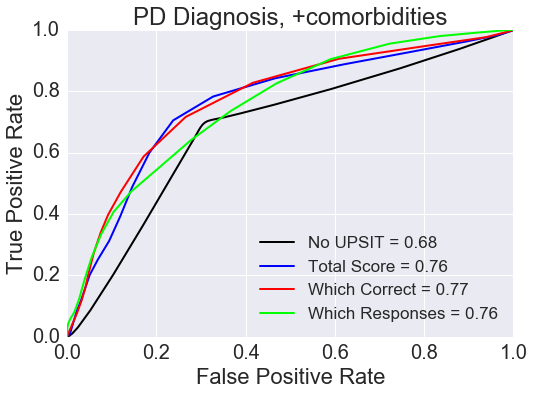

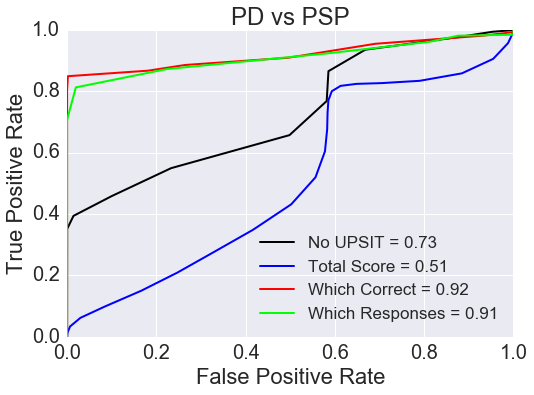

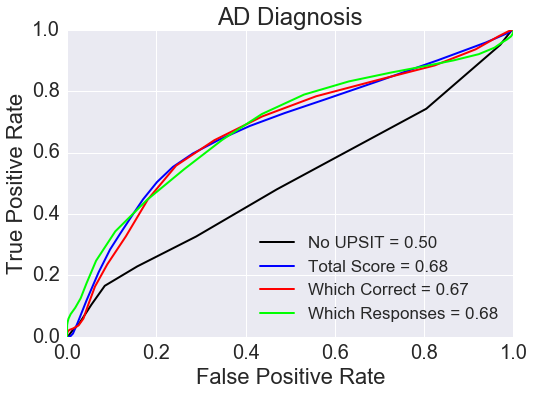

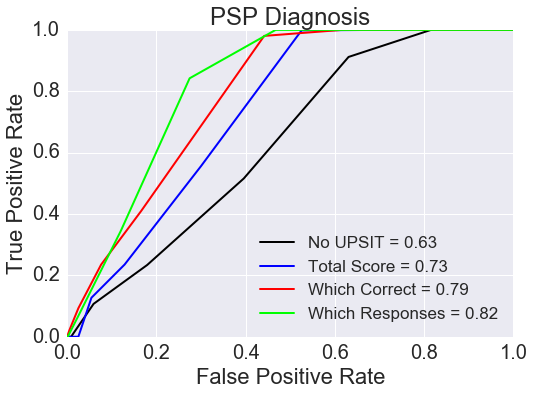

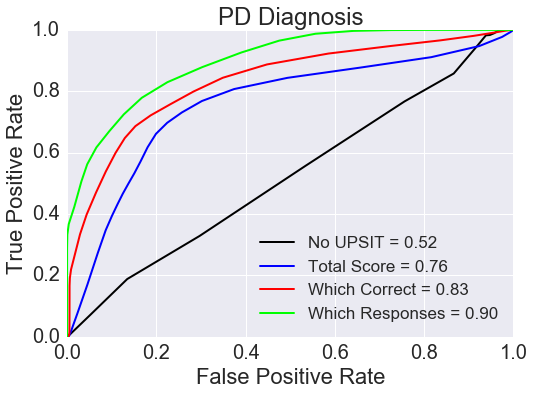

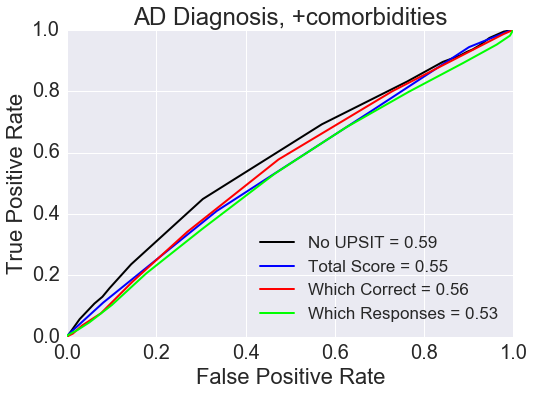

In [11]:
X,Y = makeXY(keys,uses,clin,x,drop_more=['Last MMSE Test Score'])
p_pos,ys = make_py(keys,uses,X,Y,clfs)
p_pos = make_average_p(p_pos,clfs)
for key in keys:
    plt.figure()
    d = {use:p_pos[key][use]['average'] for use in uses}
    s.plot_roc_curve(ys[key],smooth=True,**d)
    plt.title(keys[key])

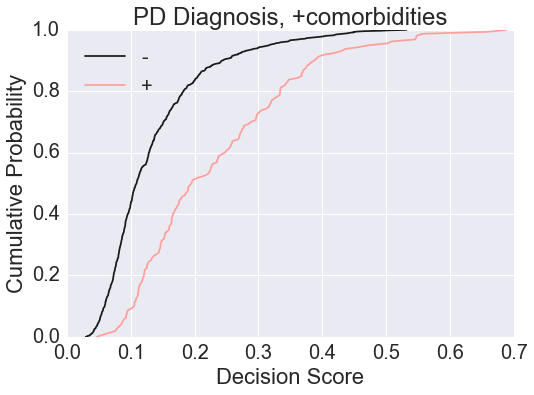

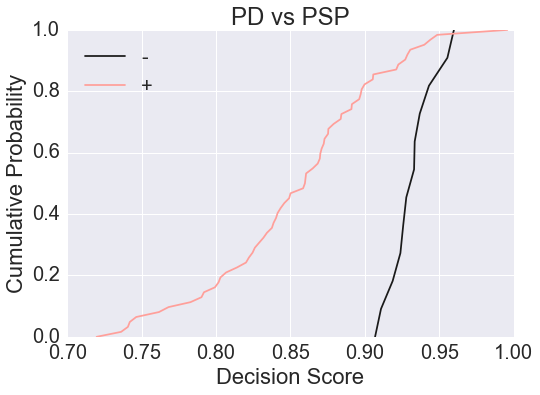

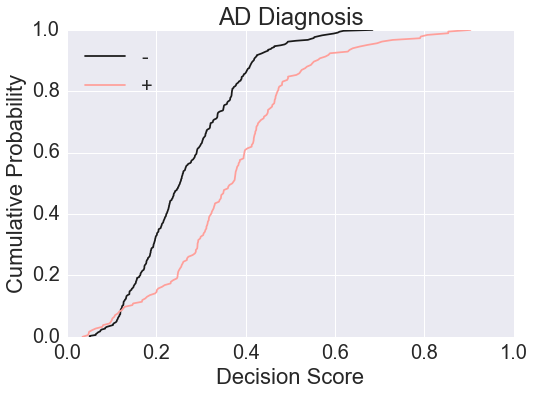

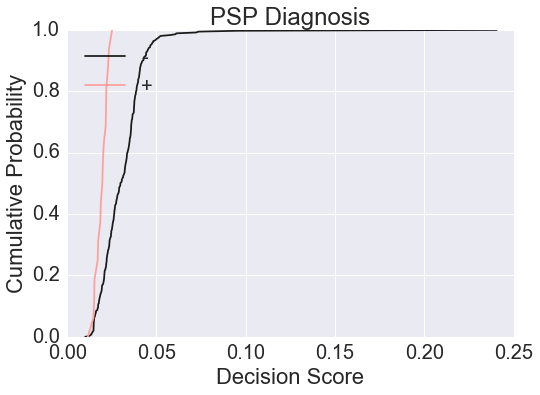

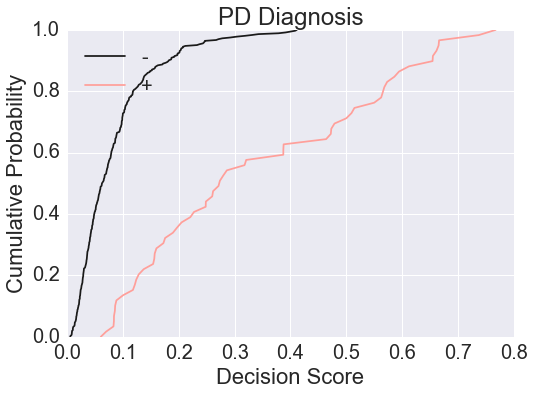

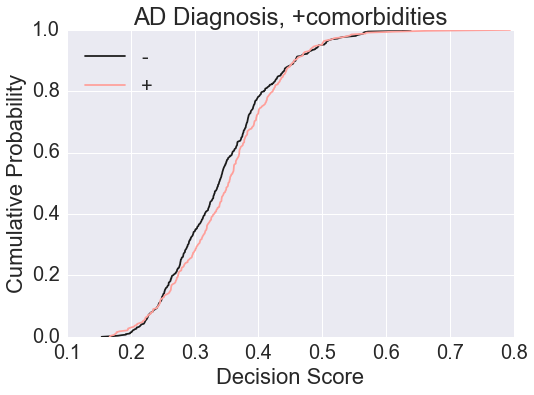

In [12]:
for key in keys:
    plt.figure()
    s.plot_cumul(p_pos[key]['Which Responses']['average'][:,None],ys[key],'Decision Score')
    plt.title(keys[key])

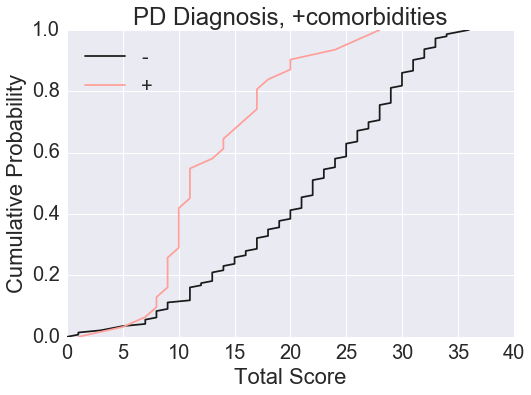

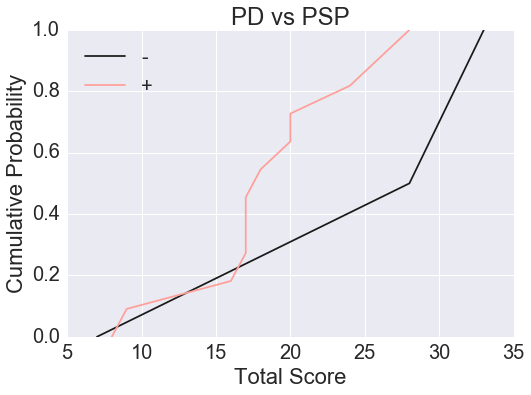

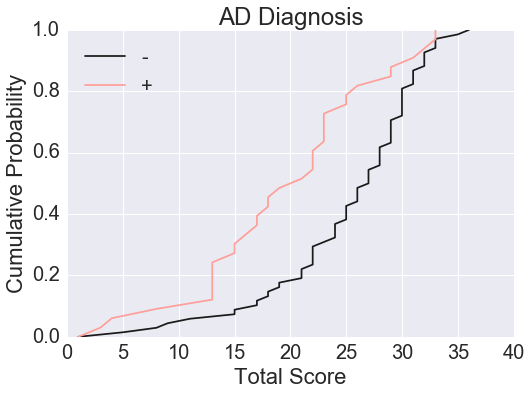

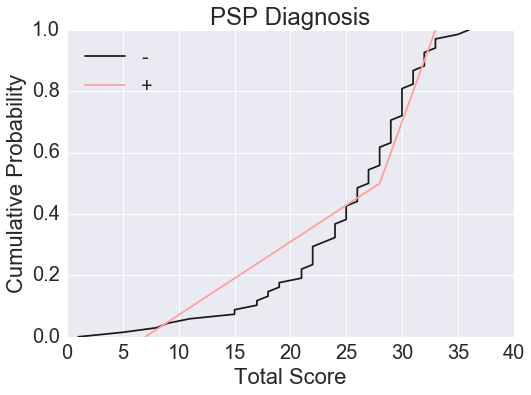

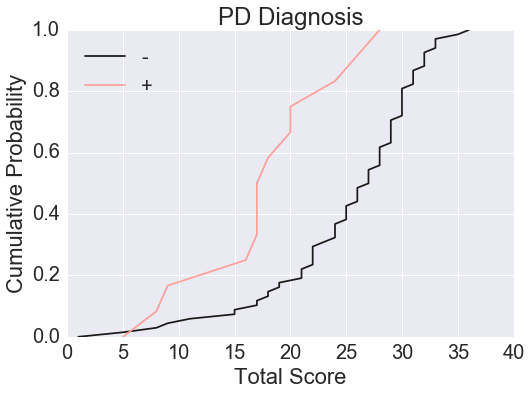

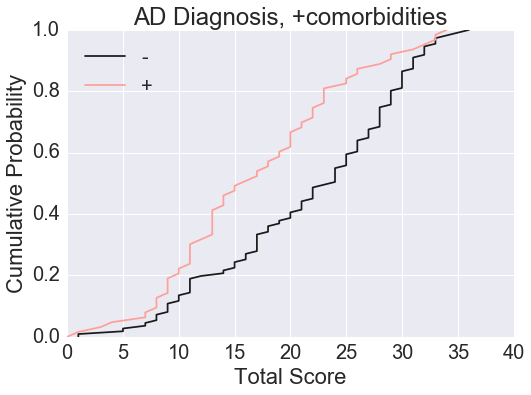

In [13]:
for key in keys:
    plt.figure()
    s.plot_cumul(X[key]['Total Score'][:,-1:],Y[key],'Total Score')
    plt.title(keys[key])

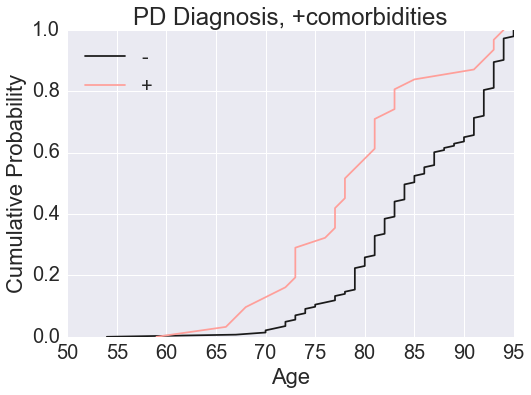

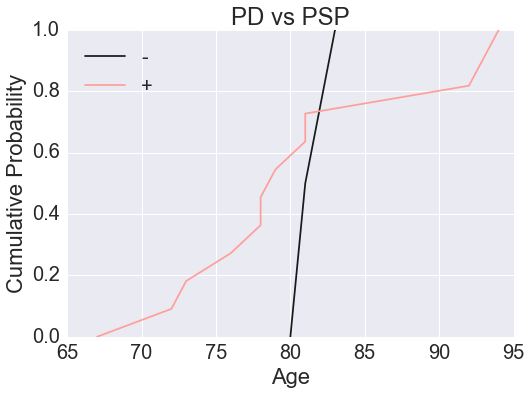

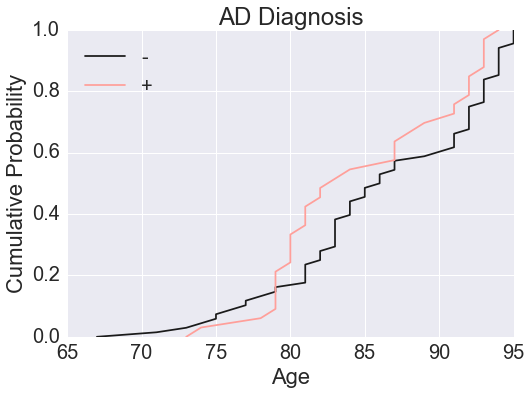

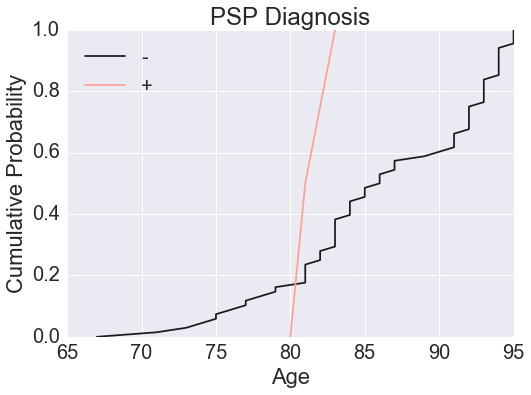

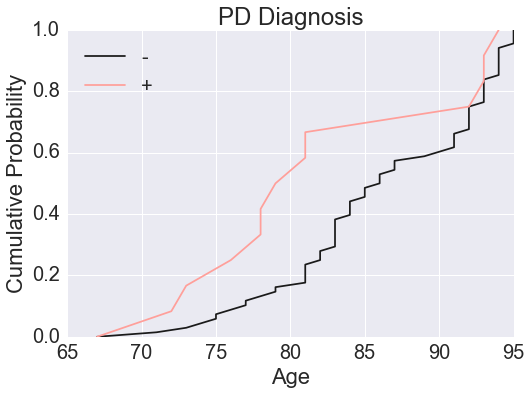

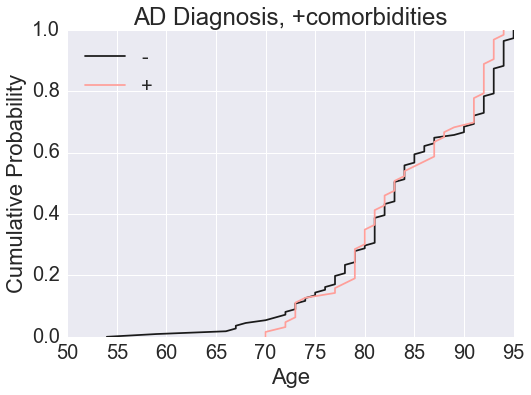

In [14]:
for key in keys:
    plt.figure()
    s.plot_cumul(X[key]['Total Score'][:,3:4],Y[key],'Age')
    plt.title(keys[key])

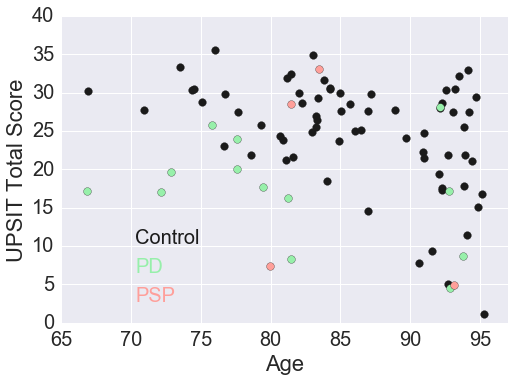

In [15]:
for color,label,subset in [('k','Control',(df['Clinpath Control']==1) & (df['Clinpath PSP']==0)),
                     ('g','PD',(df['Clinpath PD']==1) & (df['dementia']==0)),
                     ('r','PSP',(df['Clinpath PSP']==1) & (df['dementia']==0))]:
    z = clin[subset]
    n = z.shape[0]
    plt.scatter(z['age']+np.random.rand(n)-0.5,
                z['upsit_total_correct']+np.random.rand(n)-0.5,
                c=color,
                s=60,
                label=label)
plt.xlabel('Age')
plt.ylabel('UPSIT Total Score')
plt.xlim(65,97)
plt.ylim(0,40)
l = plt.legend(loc=3,markerscale=0)
for i,text in enumerate(l.get_texts()):
    text.set_color('kgr'[i])

/Users/rgerkin/Dropbox/miniconda3/lib/python3.5/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)


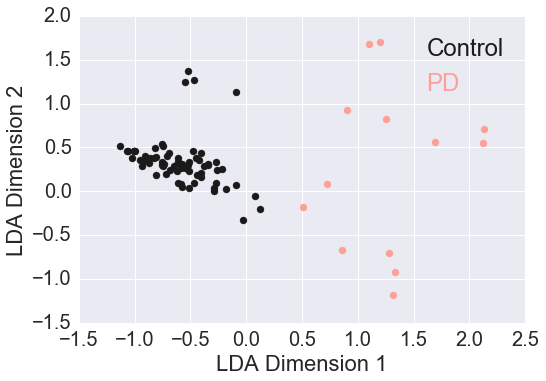

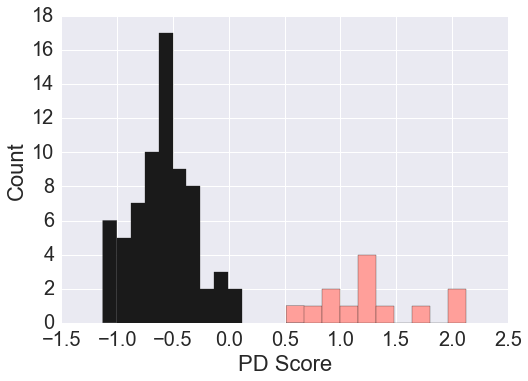

In [16]:
z = clin.join(df.loc[clin.index,:][['Clinpath Control','Clinpath PD','dementia']])
z = z[(z['dementia']==0) & ((z['Clinpath Control']==1) | (z['Clinpath PD']==1))]
pattern = [f for f in list(z) if re.match('upsit_[0-9]+[a-d]',f)]
lda = LinearDiscriminantAnalysis(shrinkage='auto',solver='eigen')#,n_components=2)
ft = lda.fit_transform(z[pattern],z['Clinpath PD'])
lda_shuff = {}
ft_shuff = {}
n_shuff = 1000
for i in range(n_shuff):
    lda_shuff[i] = LinearDiscriminantAnalysis(shrinkage='auto',solver='eigen')#,n_components=2)
    z_shuff = z.copy()
    z_shuff['Clinpath PD'] = np.random.rand(z.shape[0])<z['Clinpath PD'].mean()
    ft_shuff[i] = lda_shuff[i].fit_transform(z_shuff[pattern],z_shuff['Clinpath PD'])
sns.set(font_scale=2)
for i in [0,1]:
    index = np.where(z['Clinpath PD']==i)
    plt.figure(1)
    plt.scatter(ft[index,0],ft[index,1],color='kr'[i],s=50,label=['Control','PD'][i])
    plt.figure(2)
    plt.hist(ft[index,0].ravel(),bins=10,color='kr'[i])
plt.figure(1)
lgd = plt.legend(markerscale=0,fontsize=24)
plt.xlabel('LDA Dimension 1')
plt.ylabel('LDA Dimension 2')
for i,text in enumerate(lgd.get_texts()):
    text.set_color('kr'[i])
plt.figure(2)
plt.xlabel('PD Score')
plt.ylabel('Count')

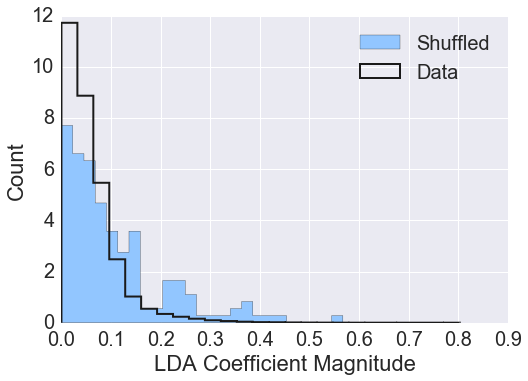

In [17]:
plt.hist(np.abs(lda.coef_.T),color='b',bins=25,normed=True,histtype='stepfilled',label='Shuffled')
shuff_coefs = np.abs(np.ravel([lda_shuff[i].coef_.T for i in range(n_shuff)]))
plt.hist(shuff_coefs,bins=25,color='k',normed=True,histtype='step',linewidth=2,label='Data');
plt.xlabel('LDA Coefficient Magnitude')
plt.ylabel('Count')
plt.legend()

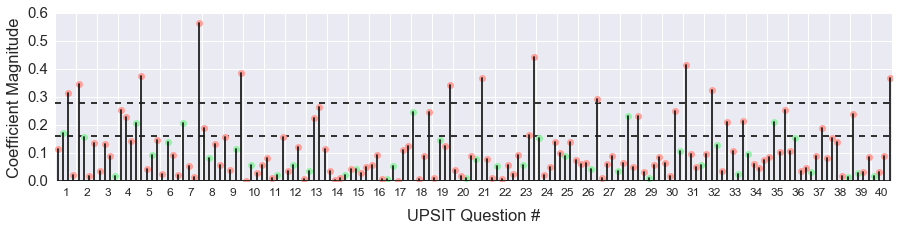

In [18]:
correct_answers = np.array(correct)-1+np.arange(0,160,4)
incorrect_answers = np.array(list(set(range(160)).difference(correct_answers)))
sns.set(font_scale=1.5)
plt.figure(figsize=(15,3))
plt.stem(1.125+correct_answers/4,np.abs(lda.coef_.T[correct_answers]),linefmt='k-', markerfmt='go', basefmt='k-')
plt.stem(1.125+incorrect_answers/4,np.abs(lda.coef_.T[incorrect_answers]),linefmt='k-', markerfmt='ro', basefmt='k-')
plt.hlines(np.percentile(shuff_coefs,95),1,41,linestyle='--')
plt.hlines(np.percentile(shuff_coefs,99),1,41,linestyle='--')
plt.xticks(range(1,41,1),[""]*40,rotation=0,fontsize=14);
plt.xlim(1,41)
for i in range(1,41):
    plt.text(i+0.5,-0.05,i,fontsize=12,ha='center')
plt.xlabel('UPSIT Question #',labelpad=20)
plt.ylabel('Coefficient Magnitude')

In [19]:
test_key = pd.read_excel('bbdp/data/GerkinSmithUPSITautopsy9_10_14.xlsx',sheetname='smellTestKey').drop('Unnamed: 4',1)

In [20]:
pd = clin[((df['Clinpath PD']==1) & (df['Clinpath AD']==0) & (df['Clinpath PSP']==0))]
no_pd = clin[((df['Clinpath PD']==0) & (df['Clinpath AD']==0) & (df['Clinpath PSP']==0))]

In [21]:
coefs = sorted(np.abs(lda.coef_.T).ravel(),reverse=True)
ps = [(shuff_coefs>coef).mean() for coef in coefs]
ps = [ps[i]*80/(i+1) for i in range(len(coefs))]
#print(ps)
print("Q) Response (Correct), PD vs CTRL")
for i,coef in enumerate(lda.coef_.T):
    question = int(i/4)+1
    letter = 'abcd'[i%4]
    if coef>np.percentile(shuff_coefs,99):
        correct = test_key['Correct answer'].loc['smell %d' % question]
        row = 'smell %d' % question
        pd_f = pd['upsit_%d%s' % (question,letter)].mean()
        no_pd_f = no_pd['upsit_%d%s' % (question,letter)].mean()
        print('%d) %s (%s),& %.2f & %.2f' % (question,test_key.loc[row,correct],test_key.loc[row,(i%4)+1],pd_f,no_pd_f))

Q) Response (Correct), PD vs CTRL
1) pizza (peanuts),& 0.22 & 0.07
2) bubble gum ( dill pickle),& 0.22 & 0.06
5) motor oil (grass),& 0.43 & 0.14
7) banana (motor oil),& 0.48 & 0.07
9) leather  (apple),& 0.26 & 0.04
19) chocolate (black pepper),& 0.35 & 0.04
21) lilac (chili),& 0.39 & 0.06
23) peach (pizza),& 0.13 & 0.01
26) pineapple (onion),& 0.30 & 0.06
31) paint thinner (watermelon),& 0.22 & 0.03
32) grass (gingerbread),& 0.39 & 0.17
40) peanut (root beer),& 0.22 & 0.06


In [22]:
test_key

,1,2,3,4,Correct answer
smell 1,gasoline,pizza,peanuts,lilac,2
smell 2,dill pickle,bubble gum,wintergreen,watermelon,2
smell 3,tomato,locorice,strawberry,menthol,4
smell 4,whiskey,honey,lime,cherry,4
smell 5,grass,pizza,motor oil,pineapple,3
smell 6,skunk,mint,fruit punch,cola,2
smell 7,banana,garlic,cherry,motor oil,1
smell 8,motor oil,clove,chili,banana,2
smell 9,clove,lilac,leather,apple,3
smell 10,skunk,coconut,cedar,honey,2
